<a href="https://colab.research.google.com/github/shh2003/Machine-Learning/blob/main/week04/Mhealth_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이트세트 정보만 주고요. 일단 데이터 읽어서 subject 번호가 컬럼면에 포함된 통합 data frame 만들고 CNN, LSTM, CNN-LSTM 해보기.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical


In [172]:
from google.colab import drive
import pandas as pd
import glob
import re

# Google Drive 마운트
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
# MHEALTHDATASET 폴더 경로
data_path = "/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET"

# 모든 .log 파일 경로 가져오기
log_files = glob.glob(data_path + "/mHealth_subject*.log")

print("파일 목록:")
for f in log_files:
    print(f)


파일 목록:
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject2.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject4.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject3.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject10.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject1.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject8.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject6.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject7.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject5.log
/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET/mHealth_subject9.log


In [174]:
# 각 파일을 데이터프레임으로 읽어 리스트에 저장합니다.
all_data_frames = []
for file_path in log_files:
    # 파일을 데이터프레임으로 읽어옵니다. (탭으로 구분, 헤더 없음)
    df = pd.read_csv(file_path, sep='\t', header=None)

    # 파일 경로에서 subject 번호를 추출합니다.

    match = re.search(r'subject(\d+)', file_path)
    if match:
        subject_id = int(match.group(1))
        # 'subject' 열을 추가합니다.
        df['subject'] = subject_id
        all_data_frames.append(df)

# 모든 데이터프레임을 하나로 통합합니다.

combined_df = pd.concat(all_data_frames, ignore_index=True)



combined_df.head()



,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,subject
0,-9.8646,0.298600,1.6900,-0.25955,-0.146520,0.49965,-9.6680,1.5216,-0.47866,-0.53471,...,-8.2508,1.9208,-0.98039,-0.41889,0.18966,0.72891,1.07810,-0.357210,0,2
1,-9.7753,0.381060,1.6132,-0.12977,-0.058608,0.40572,-9.5801,1.4001,-0.48423,-0.54409,...,-8.2609,1.9099,-0.98039,-0.41889,0.18966,0.18670,0.71683,-0.725460,0,2
2,-9.6195,0.169430,1.7205,-0.10466,-0.037677,0.42741,-9.6488,1.4593,-0.48423,-0.54409,...,-8.3198,2.0215,-0.97647,-0.42094,0.20043,0.18855,0.90189,-0.366260,0,2
3,-9.7610,0.169380,1.5837,-0.11722,-0.037677,0.32193,-9.4522,1.3119,-0.48423,-0.54409,...,-8.4318,1.8180,-0.97647,-0.42094,0.20043,0.18677,0.72405,-0.003505,0,2
4,-9.8078,-0.013582,1.6514,-0.13815,-0.054422,0.46731,-9.6397,1.3769,-0.49165,-0.52345,...,-8.4420,1.7966,-0.97647,-0.42094,0.20043,0.74339,2.52610,-0.732410,0,2


In [175]:
# MHEALTH 데이터셋의 컬럼명을 순서대로 리스트로 정의합니다.

column_names = [
    'acc_ch_x', 'acc_ch_y', 'acc_ch_z', # Chest Accelerometer
    'ecg_1', 'ecg_2',                  # Electrocardiogram (이 부분이 추가되었습니다)
    'acc_la_x', 'acc_la_y', 'acc_la_z', # Left-Ankle Accelerometer
    'gyr_la_x', 'gyr_la_y', 'gyr_la_z', # Left-Ankle Gyroscope
    'mag_la_x', 'mag_la_y', 'mag_la_z', # Left-Ankle Magnetometer
    'acc_rw_x', 'acc_rw_y', 'acc_rw_z', # Right-Wrist Accelerometer
    'gyr_rw_x', 'gyr_rw_y', 'gyr_rw_z', # Right-Wrist Gyroscope
    'mag_rw_x', 'mag_rw_y', 'mag_rw_z', # Right-Wrist Magnetometer
    'activity',
    'subject'
]

combined_df.columns = column_names
# 결과 확인

print("\n## 📊 데이터프레임 미리보기")
combined_df


## 📊 데이터프레임 미리보기


,acc_ch_x,acc_ch_y,acc_ch_z,ecg_1,ecg_2,acc_la_x,acc_la_y,acc_la_z,gyr_la_x,gyr_la_y,...,acc_rw_y,acc_rw_z,gyr_rw_x,gyr_rw_y,gyr_rw_z,mag_rw_x,mag_rw_y,mag_rw_z,activity,subject
0,-9.8646,0.298600,1.690000,-0.25955,-0.146520,0.49965,-9.6680,1.52160,-0.478660,-0.53471,...,-8.2508,1.9208,-0.98039,-0.41889,0.18966,0.72891,1.07810,-0.357210,0,2
1,-9.7753,0.381060,1.613200,-0.12977,-0.058608,0.40572,-9.5801,1.40010,-0.484230,-0.54409,...,-8.2609,1.9099,-0.98039,-0.41889,0.18966,0.18670,0.71683,-0.725460,0,2
2,-9.6195,0.169430,1.720500,-0.10466,-0.037677,0.42741,-9.6488,1.45930,-0.484230,-0.54409,...,-8.3198,2.0215,-0.97647,-0.42094,0.20043,0.18855,0.90189,-0.366260,0,2
3,-9.7610,0.169380,1.583700,-0.11722,-0.037677,0.32193,-9.4522,1.31190,-0.484230,-0.54409,...,-8.4318,1.8180,-0.97647,-0.42094,0.20043,0.18677,0.72405,-0.003505,0,2
4,-9.8078,-0.013582,1.651400,-0.13815,-0.054422,0.46731,-9.6397,1.37690,-0.491650,-0.52345,...,-8.4420,1.7966,-0.97647,-0.42094,0.20043,0.74339,2.52610,-0.732410,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-12.2440,-2.970600,-0.035772,0.81214,1.096800,0.57061,-2.5602,0.41936,-0.055659,0.64165,...,-16.9660,2.3704,0.10980,-0.99384,0.19181,-6.12870,15.49500,18.856000,0,9
1215741,-10.9220,-3.419000,-0.339280,1.46940,1.285200,5.26840,-4.9331,9.66020,-0.055659,0.64165,...,-13.3900,2.9972,0.10980,-0.99384,0.19181,-10.24200,17.13900,33.920000,0,9
1215742,-9.4842,-3.064300,-1.033700,0.23862,0.891680,0.53805,-5.9706,2.93600,-0.055659,0.64165,...,-11.3790,3.1498,0.10980,-0.99384,0.19181,-12.94400,16.17000,43.262000,0,9
1215743,-8.7889,-2.475700,-0.612290,-0.20513,0.460490,1.56950,-7.9809,-2.05000,-0.085343,0.43715,...,-10.0000,3.0000,0.11961,-0.97331,0.15302,-14.52400,1.84940,43.373000,0,9


In [176]:
combined_df.columns

Index(['acc_ch_x', 'acc_ch_y', 'acc_ch_z', 'ecg_1', 'ecg_2', 'acc_la_x',
       'acc_la_y', 'acc_la_z', 'gyr_la_x', 'gyr_la_y', 'gyr_la_z', 'mag_la_x',
       'mag_la_y', 'mag_la_z', 'acc_rw_x', 'acc_rw_y', 'acc_rw_z', 'gyr_rw_x',
       'gyr_rw_y', 'gyr_rw_z', 'mag_rw_x', 'mag_rw_y', 'mag_rw_z', 'activity',
       'subject'],
      dtype='object')

In [177]:
combined_df.isnull().sum()

,0
acc_ch_x,0
acc_ch_y,0
acc_ch_z,0
ecg_1,0
ecg_2,0
acc_la_x,0
acc_la_y,0
acc_la_z,0
gyr_la_x,0
gyr_la_y,0


In [178]:
combined_df['subject'].value_counts()

,count
subject,
1,161280
9,135168
2,130561
8,129024
3,122112
5,119808
4,116736
7,104448
10,98304


In [179]:
print("## 'activity' 컬럼의 값 분포")
print(combined_df['activity'].value_counts())

## 'activity' 컬럼의 값 분포
activity
0     872550
5      30720
1      30720
2      30720
3      30720
4      30720
9      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


In [180]:
combined_df.shape

(1215745, 25)

In [181]:
X = combined_df.drop(['subject', 'activity'], axis=1)
y = combined_df['activity']

In [182]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [183]:
# 1. LabelEncoder 객체를 생성합니다.
encoder = LabelEncoder()

# 2. fit_transform()을 사용하여 'y' 데이터를 라벨 인코딩합니다.
#    .values.reshape(-1, 1) 부분이 필요 없어 코드가 더 간단해집니다.
y_encoded = encoder.fit_transform(y)

In [184]:
print(f"특징 데이터 형태: {X_scaled.shape}")
print(f"레이블 데이터 형태: {y_encoded.shape}")

특징 데이터 형태: (1215745, 23)
레이블 데이터 형태: (1215745,)


In [185]:
window_size = 128
step = 64
# (이전 단계에서 y_encoded가 LabelEncoder로 생성되었다고 가정)

window_size = 128
step = 64
X_windows, y_windows = [], []

# 윈도우 생성 루프
for i in range(0, len(X_scaled) - window_size, step):
    # 특징 데이터 윈도우 추출
    window = X_scaled[i : i + window_size]

    # 레이블 데이터 윈도우 추출
    label_vector = y_encoded[i : i + window_size]

    # ★★★ 이 부분이 변경되었습니다 ★★★
    # 1차원 배열(label_vector)에서 가장 빈번하게 등장하는 값을 찾습니다.
    # np.bincount가 각 숫자의 빈도를 세고, np.argmax가 가장 빈도가 높은 숫자를 반환합니다.
    most_common_label = np.argmax(np.bincount(label_vector))

    X_windows.append(window)
    y_windows.append(most_common_label)

# 리스트를 Numpy 배열로 변환
X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

# 결과 확인
print("생성된 X 데이터 형태:", X_windows.shape)
print("생성된 y 데이터 형태:", y_windows.shape)

생성된 X 데이터 형태: (18995, 128, 23)
생성된 y 데이터 형태: (18995,)


In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows_encoded, test_size=0.2, random_state=42, stratify=y_windows_encoded
)


In [187]:
# --- 5. CNN 모델 구축 및 훈련 ---
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1]

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Dropout(0.5),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [188]:

# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6927 - loss: 1.1960 - val_accuracy: 0.7665 - val_loss: 0.5060
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7594 - loss: 0.5740 - val_accuracy: 0.7992 - val_loss: 0.4022
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7711 - loss: 0.4930 - val_accuracy: 0.8049 - val_loss: 0.3674
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7927 - loss: 0.4531 - val_accuracy: 0.8242 - val_loss: 0.3482
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7926 - loss: 0.4372 - val_accuracy: 0.8386 - val_loss: 0.3271
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8079 - loss: 0.4054 - val_accuracy: 0.8492 - val_loss: 0.3180
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8185 - loss: 0.3914 - val_accuracy: 0.8410 - val_loss: 0.3133
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8261 - loss: 0.3736 - 

In [189]:
def plot_history(history):
    plt.figure(figsize=(10, 8))
    sns.set_theme()
    # --- 정확도 ---
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], 'r-', label='Train')
    plt.plot(history.history['val_accuracy'], 'b-', label='Val')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # --- 손실 ---
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], 'r-', label='Train')
    plt.plot(history.history['val_loss'], 'b-', label='Val')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

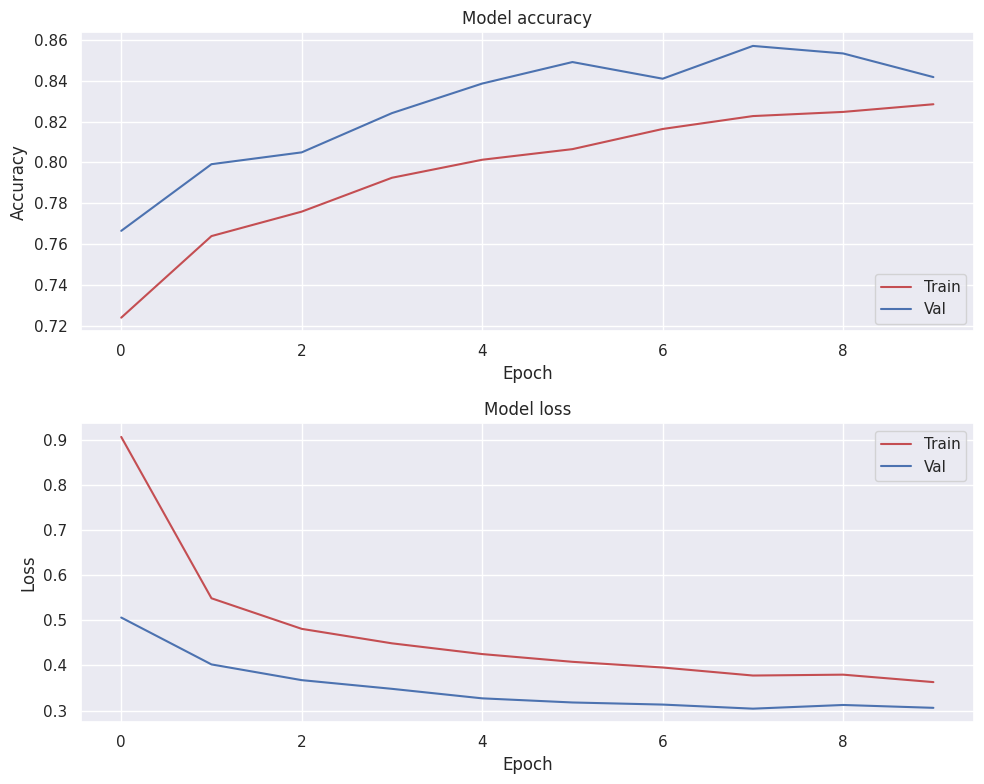

In [190]:
plot_history(history)

In [191]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. 모델 예측 ---
# 테스트 데이터(X_test)로 모델의 예측을 수행합니다.
y_pred_probs = model.predict(X_test)

# --- 2. 데이터 형식 변환 ---
# 예측값과 실제 정답의 형식을 동일하게 맞춰줍니다.
# 원-핫 인코딩된 벡터에서 가장 확률이 높은 클래스의 번호(인덱스)를 추출합니다.
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- 3. 최종 결과 출력 ---
print("\n" + "="*50)
print("최종 모델 평가 결과")
print("="*50)

# 활동별 정밀도, 재현율, f1-점수를 보여주는 분류 보고서 출력
print("\n[ 분류 보고서 (Classification Report) ]")
print(classification_report(y_true, y_pred))

# 모델이 어떤 클래스를 무엇으로 혼동했는지 보여주는 혼동 행렬 출력
print("\n[ 혼동 행렬 (Confusion Matrix) ]")
print(confusion_matrix(y_true, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

최종 모델 평가 결과

[ 분류 보고서 (Classification Report) ]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2730
           1       0.62      0.80      0.70        95
           2       0.72      0.60      0.66        96
           3       0.65      1.00      0.79        96
           4       0.83      0.36      0.51        96
           5       0.81      0.56      0.66        96
           6       0.64      0.92      0.75        88
           7       0.60      0.58      0.59        91
           8       0.79      0.77      0.78        91
           9       0.83      0.77      0.80        96
          10       0.76      0.81      0.78        96
          11       0.71      0.99      0.83        96
          12       0.00      0.00      0.00        32

    accuracy                           0.84      3799
   macro avg       0.68      0.70      0.67      3799
weighted avg       0.84      0.84      0.84 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [192]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# --- 최종 평가 요약 함수 정의 ---
def results_summarizer(y_true, y_pred):
    """
    분류 모델의 평가 지표와 혼동 행렬을 계산하고 시각화하는 함수.

    Args:
        y_true (array): 실제 정답 레이블 (숫자 형태)
        y_pred (array): 모델의 예측 레이블 (숫자 형태)
    """
    # 1. 평가 지표 계산
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # 2. 활동 이름 맵핑 (MHEALTH 데이터셋의 13개 전체 활동)
    activity_map = {
        0: 'Null',
        1: 'Standing still',
        2: 'Sitting and relaxing',
        3: 'Lying down',
        4: 'Walking',
        5: 'Climbing stairs',
        6: 'Waist bends forward',
        7: 'Frontal elevation of arms',
        8: 'Knees bending (crouching)',
        9: 'Cycling',
        10: 'Jogging',
        11: 'Running',
        12: 'Jump front & back'
    }

    # 3. 혼동 행렬 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=activity_map.values(),
        yticklabels=activity_map.values()
    )
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Activity (예측값)', fontsize=14)
    plt.ylabel('Actual Activity (실제값)', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

    # 4. 평가 점수 출력
    print("="*50)
    print("📊 최종 평가 점수")
    print("="*50)
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F1 Score: ' + '{:.4%}'.format(f1))


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


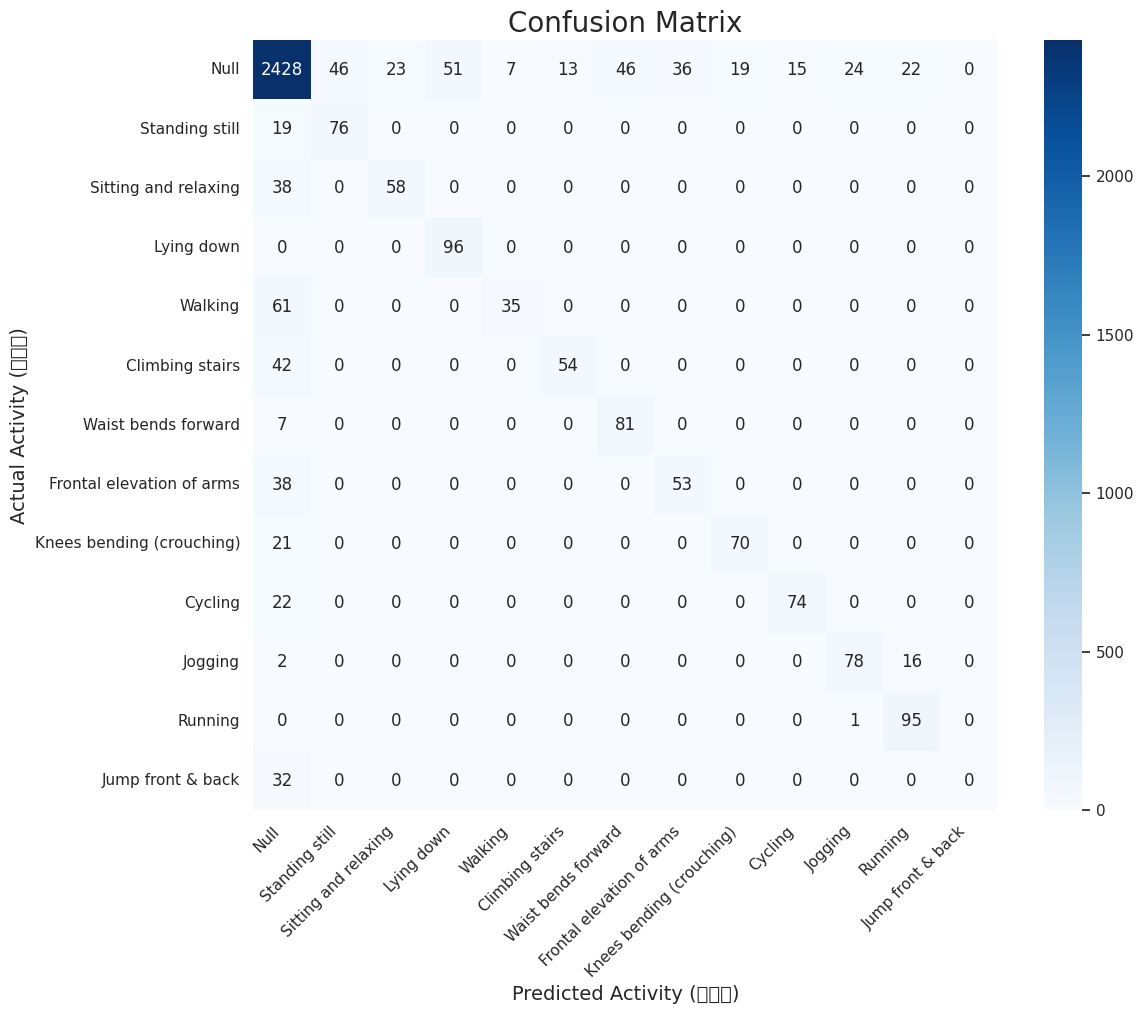

📊 최종 평가 점수
Accuracy Score: 84.1800%
Precision Score: 68.0781%
Recall Score: 69.7357%
F1 Score: 67.2476%


In [193]:
results_summarizer(y_true, y_pred)